# TRANSFORMER SIMPLE MODEL

## GPU info

In [1]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Check if GPU is available
from tensorflow.python.client import device_lib

def get_gpu_details():
    devices = device_lib.list_local_devices()
    for device in devices:
        if device.device_type == 'GPU':
            print(f"Device Name: {device.name}")
            print(f"Memory Limit: {device.memory_limit} bytes")
            print(f"Description: {device.physical_device_desc}")

get_gpu_details()


Device Name: /device:GPU:0
Memory Limit: 4158652416 bytes
Description: device: 0, name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


### Config

In [4]:
max_length = 15 # Length of input and target sequences, padding

### Import libraries

In [5]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

import re
import string
import unicodedata
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import numpy as np
import pandas as pd
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout, GlobalAveragePooling1D, Layer, Masking
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

import pickle


In [6]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Keras version:", tf.keras.__version__)

TensorFlow version: 2.10.0
TensorFlow Keras version: 2.10.0


In [7]:
# Download necessary NLTK resources
nltk.download('punkt')  # Tokenizer
nltk.download('wordnet')  # Lemmatizer
nltk.download('stopwords')  # Stopwords
nltk.download('omw-1.4') # Ensures multilingual contexts

# Stopwords list
stop_words = set(stopwords.words('english'))

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

initial_preprocessing = True

# Load spaCy's English NLP model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\tomui\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Create prepocessing functions for initial text and later response generation preprocessing

In [8]:
contractions = {
    "’": "'",
    "‘": "'",
    "“": '"',
    "”": '"',
    "can't": "cannot",
    "won't": "will not",
    "n't": " not",
    "i'm": "i am",
    "i'd": "i would",
    "thats's": "that is",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "you're": "you are",
    "they're": "they are",
    "we're": "we are",
    "i've": "i have",
    "you've": "you have",
    "they've": "they have",
    "we've": "we have",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "doesn't": "does not",
    "don't": "do not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "i'll": "i will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "we'll": "we will",
    "they'll": "they will",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mightn't": "might not",
    "mustn't": "must not",
    "she'd": "she would",
    "he'd": "he would",
    "they'd": "they would",
    "we'd": "we would",
    "that'll": "that will",
    "there'll": "there will",
    "who'll": "who will",
    "it'll": "it will",
    "that'd": "that would",
    "there'd": "there would",
    "who'd": "who would",
    "when's": "when is",
    "where's": "where is",
    "why's": "why is",
    "how's": "how is",
    "y'all": "you all",
    "let's": "let us",
    "ma'am": "madam",
    "o'clock": "of the clock",
    "ain't": "is not",
    "could've": "could have",
    "should've": "should have",
    "would've": "would have",
    "might've": "might have",
    "must've": "must have",
    "who've": "who have",
    "oughtn't": "ought not",
    "daren't": "dare not",
    "needn't": "need not",
    "what's": "what is",
    "usedn't": "used not"
}

def normalize_text(text: str) -> str:
    # Normalize Unicode string to NFKD form, remove non-ASCII characters, and then decode it back to a UTF-8 string
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    # Convert to lowercase
    text = text.lower()
    # Remove spaces around apostrophes
    text = re.sub(r"\s*'\s*", "'", text)
    # Add a space before and after any punctuation mark (., !, or ?)
    text = re.sub(r"\s*([.!?])\s*", r" \1 ", text)
    # Correct contractions
    for contraction, replacement in contractions.items():
        text = re.sub(re.escape(contraction), replacement, text)
    # Replace any sequence of characters that are not letters, basic punctuation
    text = re.sub(r"[^a-z' ]", ' ', text) # re.sub(r"[^a-z.,'!? ]", ' ', text)
    # Replace any sequence of whitespace characters with a single space and remove leading and trailing whitespace
    text = re.sub(r"\s+", ' ', text).strip()
    return text

def remove_names(text: str) -> str:
    # Use spaCy to detect and remove names from the text
    doc = nlp(text)
    filtered_text = ' '.join([token.text for token in doc if token.ent_type_ != 'PERSON']) # Takes really long time, exlude from chatbot input preprocessing
    return filtered_text

def preprocess_text(text: str) -> str:
    # Normalize text
    text = normalize_text(text)
    # Remove names using spaCy's NER
    if initial_preprocessing:
        text = remove_names(text)
    # # Remove punctuation
    # text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords and tokenize
    # words = word_tokenize(text) # More intelligent splitting
    # filtered_words = [word for word in words if word not in stop_words]
    # # Lemmatize words
    # lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Add <SOS> and <EOS> tokens, and join the list into a single string
    # return ' '.join(['sofs'] + lemmatized_words + ['eofs'])
        # Trim the text to the desired length
    words = text.split()[:max_length]
    trimmed_text = ' '.join(words)  # Consider to remove trimming, if you want pad later on max length
    return trimmed_text

### Load the Tokenizer

In [9]:
# Load the tokenizer from file
data_dir = os.path.join(os.getcwd(), 'data')
tokenizer_path = os.path.join(data_dir, 'tokenizer_dd_tf210.pickle')
with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

### Loading the DataFrame

In [10]:
# Loading the DataFrame
data_dir = os.path.join(os.getcwd(), 'data')
file_path_parquet = os.path.join(data_dir, 'training_df_dd_tf210.parquet')
training_data_final = pd.read_parquet(file_path_parquet)

training_data_final.head(10)

,input,response,encoder_input_data,decoder_input_data,decoder_output_data
0,say how about going for a few beers after dinner,you know that is tempting but is really not go...,"[0, 0, 0, 0, 0, 138, 33, 37, 75, 20, 8, 206, 3...","[0, 0, 1, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 4...","[0, 0, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 47, ..."
1,you know that is tempting but is really not go...,what do you mean it will help us to relax,"[0, 0, 5, 46, 11, 9, 3717, 29, 9, 60, 15, 47, ...","[0, 0, 0, 0, 0, 1, 18, 13, 5, 161, 10, 23, 101...","[0, 0, 0, 0, 0, 18, 13, 5, 161, 10, 23, 101, 9..."
2,what do you mean it will help us to relax,do you really think so i do not it will just m...,"[0, 0, 0, 0, 0, 18, 13, 5, 161, 10, 23, 101, 9...","[1, 13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, ...","[13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, 102..."
3,do you really think so i do not it will just m...,i guess you are right but what shall we do i d...,"[13, 5, 60, 43, 36, 4, 13, 15, 10, 23, 48, 102...","[1, 4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4,...","[4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4, 13..."
4,i guess you are right but what shall we do i d...,i suggest a walk over to the gym where we can ...,"[4, 226, 5, 17, 53, 29, 18, 325, 22, 13, 4, 13...","[1, 4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 2...","[4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 21, ..."
5,i suggest a walk over to the gym where we can ...,that 's a good idea i hear mary and sally ofte...,"[4, 593, 8, 423, 140, 7, 6, 973, 105, 22, 21, ...","[1, 11, 38, 8, 47, 179, 4, 237, 441, 14, 3323,...","[11, 38, 8, 47, 179, 4, 237, 441, 14, 3323, 30..."
6,that 's a good idea i hear mary and sally ofte...,sounds great to me if they are willing we coul...,"[11, 38, 8, 47, 179, 4, 237, 441, 14, 3323, 30...","[1, 154, 99, 7, 26, 57, 54, 17, 1083, 22, 79, ...","[154, 99, 7, 26, 57, 54, 17, 1083, 22, 79, 200..."
7,sounds great to me if they are willing we coul...,good let us go now,"[154, 99, 7, 26, 57, 54, 17, 1083, 22, 79, 200...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 47, 74, 93, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 74, 93, 59,..."
8,good let us go now,all right,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 47, 74, 93, 59,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 50,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 53..."
9,can you do push ups,of course i can it is a piece of cake believe ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 5, 13, 1635...","[1, 16, 125, 4, 21, 10, 9, 8, 773, 16, 899, 25...","[16, 125, 4, 21, 10, 9, 8, 773, 16, 899, 254, ..."


In [11]:
print(len(tokenizer.word_index))
print(tokenizer.num_words)

15384
10000


### Set the Data

In [12]:
encoder_input_data = np.array(training_data_final['encoder_input_data'].tolist())
decoder_input_data = np.array(training_data_final['decoder_input_data'].tolist())
decoder_output_data = np.array(training_data_final['decoder_output_data'].tolist())
print(type(encoder_input_data))
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_output_data.shape)
encoder_input_data.dtype

<class 'numpy.ndarray'>
(89861, 15)
(89861, 16)
(89861, 16)


dtype('int64')

In [13]:
encoder_input_data = encoder_input_data.astype('int32')
decoder_input_data = decoder_input_data.astype('int32')
decoder_output_data = decoder_output_data.astype('int32')
encoder_input_data.dtype

dtype('int32')

### Define the Model

In [14]:
# Define Transformer Encoder
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'), 
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False, mask=None):
        attn_output = self.att(inputs, inputs, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Define Transformer Decoder
class TransformerDecoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerDecoder, self).__init__()
        self.att1 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.att2 = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'), 
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.layernorm3 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        self.dropout3 = Dropout(rate)

    def call(self, enc_output, dec_input, training=False, look_ahead_mask=None, padding_mask=None):
        att1_output = self.att1(dec_input, dec_input, attention_mask=look_ahead_mask)
        att1_output = self.dropout1(att1_output, training=training)
        out1 = self.layernorm1(dec_input + att1_output)
        
        att2_output = self.att2(out1, enc_output, attention_mask=padding_mask)
        att2_output = self.dropout2(att2_output, training=training)
        out2 = self.layernorm2(out1 + att2_output)
        
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(out2 + ffn_output)

# Define Transformer Chatbot Model
class TransformerChatbot(Model):
    def __init__(self, num_tokens, max_len, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerChatbot, self).__init__()
        self.token_emb = Embedding(num_tokens, embed_dim)
        self.position_emb_encoder = Embedding(max_len, embed_dim)
        self.position_emb_decoder = Embedding(max_len, embed_dim)
        self.encoder = TransformerEncoder(embed_dim, num_heads, ff_dim, rate)
        self.decoder = TransformerDecoder(embed_dim, num_heads, ff_dim, rate)
        self.final_layer = Dense(num_tokens, activation="softmax")
        self.masking = Masking(mask_value=0)

    def create_padding_mask(self, seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]  # add extra dimensions to add the padding to the attention logits

    def call(self, inputs, training=False):
        encoder_input, decoder_input = inputs

        # Apply masking
        encoder_input = self.masking(encoder_input)
        decoder_input = self.masking(decoder_input)

        encoder_positions = tf.range(start=0, limit=tf.shape(encoder_input)[1], delta=1)
        decoder_positions = tf.range(start=0, limit=tf.shape(decoder_input)[1], delta=1)

        enc_pos = self.position_emb_encoder(encoder_positions)
        dec_pos = self.position_emb_decoder(decoder_positions)

        enc_emb = self.token_emb(encoder_input) + enc_pos
        dec_emb = self.token_emb(decoder_input) + dec_pos

        padding_mask = self.create_padding_mask(encoder_input)
        look_ahead_mask = self.create_padding_mask(decoder_input)

        encoder_output = self.encoder(enc_emb, training=training, mask=padding_mask)
        decoder_output = self.decoder(encoder_output, dec_emb, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)

        return self.final_layer(decoder_output)

# Parameters
num_tokens = len(tokenizer.word_index) + 1
max_len_input = encoder_input_data.shape[1]
max_len_output = decoder_input_data.shape[1]
embed_dim = 512  # Embedding size for each token
num_heads = 8   # Number of attention heads
ff_dim = 1024     # Size of the hidden layer in feed-forward network inside transformer

# Instantiate the model
transformer_chatbot = TransformerChatbot(num_tokens, max(max_len_input, max_len_output), embed_dim, num_heads, ff_dim)

# Compile the model
transformer_chatbot.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# Define a model checkpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='transformer_chatbot_.h5',
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)


In [15]:
for layer in transformer_chatbot.layers:
    print(layer.name, layer.trainable)


embedding True
embedding_1 True
embedding_2 True
transformer_encoder True
transformer_decoder True
dense_4 True
masking True


### Train the Model

In [16]:
# Training the model
history = transformer_chatbot.fit(
    [encoder_input_data, decoder_input_data],
    decoder_output_data[:, :, np.newaxis],  # ensure targets are properly shaped
    batch_size=64,
    epochs=10,  
    validation_split=0.2,
    # callbacks=[checkpoint_callback]
)
print("Model training completed.")
transformer_chatbot.summary()

Epoch 1/10
1124/1124 [==============================] - 160s 139ms/step - loss: 3.8319 - val_loss: 3.4327
Epoch 2/10
1124/1124 [==============================] - 178s 158ms/step - loss: 3.3222 - val_loss: 3.2496
Epoch 3/10
1124/1124 [==============================] - 181s 161ms/step - loss: 3.1773 - val_loss: 3.1611
Epoch 4/10
1124/1124 [==============================] - 195s 173ms/step - loss: 3.0982 - val_loss: 3.0958
Epoch 5/10
1124/1124 [==============================] - 218s 194ms/step - loss: 3.0163 - val_loss: 3.0024
Epoch 6/10
1124/1124 [==============================] - 262s 233ms/step - loss: 3.3255 - val_loss: 3.2303
Epoch 7/10
1124/1124 [==============================] - 305s 271ms/step - loss: 3.1080 - val_loss: 3.1016
Epoch 8/10
1124/1124 [==============================] - 332s 295ms/step - loss: 3.0315 - val_loss: 3.0755
Epoch 9/10
1124/1124 [==============================] - 379s 337ms/step - loss: 2.9810 - val_loss: 3.0325
Epoch 10/10
1124/1124 [=======================

In [17]:
# Check GPU memory usage
!nvidia-smi


Thu May 23 11:02:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.61                 Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   90C    P0             28W /   60W |    5594MiB /   6144MiB |     88%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

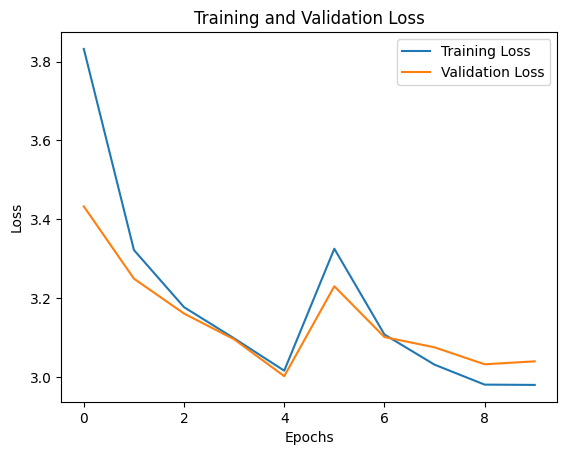

In [18]:
# Visualize training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Inference with Beam Search

In [19]:
print(tokenizer.word_index['<START>'], tokenizer.word_index['<END>'])

1 2


In [20]:
reverse_target_token_index = {index: word for word, index in tokenizer.word_index.items()}

def beam_search_decode(input_seq, beam_width=3, max_decoder_seq_length=15):
    start_token_index = tokenizer.word_index['<START>']
    end_token_index = tokenizer.word_index['<END>']
    input_seq = tf.convert_to_tensor(input_seq, dtype=tf.int32)

    # Prepare encoder input
    positions = tf.range(start=0, limit=tf.shape(input_seq)[1], delta=1)
    enc_pos = transformer_chatbot.position_emb_encoder(positions)
    enc_emb = transformer_chatbot.token_emb(input_seq) + enc_pos
    encoder_output = transformer_chatbot.encoder(enc_emb, training=False)

    # Initialize the beams
    beams = [(np.array([[start_token_index]]), 0.0)]  # (sequence, cumulative log probability)

    for _ in range(max_decoder_seq_length):
        all_candidates = []
        for seq, score in beams:
            if seq[0, -1] == end_token_index:
                all_candidates.append((seq, score))
                continue

            # Prepare decoder input
            dec_positions = tf.range(start=0, limit=tf.shape(seq)[1], delta=1)
            dec_pos = transformer_chatbot.position_emb_decoder(dec_positions)
            dec_emb = transformer_chatbot.token_emb(tf.convert_to_tensor(seq, dtype=tf.int32)) + dec_pos
            decoder_output = transformer_chatbot.decoder(encoder_output, dec_emb, training=False)
            output_tokens = transformer_chatbot.final_layer(decoder_output)

            # Select the top beam_width token predictions from the last time step
            top_k_indices = tf.math.top_k(output_tokens[0, -1], k=beam_width).indices.numpy()

            for idx in top_k_indices:
                new_seq = np.append(seq, [[idx]], axis=1)
                new_score = score + np.log(output_tokens[0, -1, idx].numpy())
                all_candidates.append((new_seq, new_score))

        # Keep top beam_width sequences
        beams = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        # If all top sequences end with the <end> token, break the loop
        if all(seq[0, -1] == end_token_index for seq, _ in beams):
            break

    best_seq, _ = beams[0]
    decoded_sentence = ' '.join([reverse_target_token_index.get(idx, '') for idx in best_seq[0] if idx not in {start_token_index, end_token_index, 0}])
    return decoded_sentence


In [21]:
test_examples = [
    "How are you doing today?",
    "What is your name?",
    "Can you help me with my homework?",
    "What is the weather like?",
    "Tell me a joke.",
    "Who is the president of the United States?",
    "What is the capital of France?",
    "Do you like pizza?",
    "What is your favorite color?",
    "Goodbye!"
]

# Preprocess input text
input_text = [preprocess_text(text) for text in test_examples]
# print(f"Preprocessed text: {input_text}")

# Tokenize and pad the test examples
test_sequences = tokenizer.texts_to_sequences(input_text)
# print(f"Tokenizer sequences: {test_sequences}")
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='pre', truncating='post')
# print(f"Padded sequences: {padded_test_sequences}")

# Generate responses with beam search
for test_seq in padded_test_sequences:
    input_seq = np.array([test_seq])
    response = beam_search_decode(input_seq, beam_width=3, max_decoder_seq_length=max_len_output)
    print(f"Input: {test_examples[padded_test_sequences.tolist().index(test_seq.tolist())]}")
    print(f"Response: {response}")
    print("-" * 50)

Input: How are you doing today?
Response: think not have to go to go to go to go to go to the
--------------------------------------------------
Input: What is your name?
Response: think not have to go to go to go to go to go to the
--------------------------------------------------
Input: Can you help me with my homework?
Response: think not you can do not you can not you can not you will be
--------------------------------------------------
Input: What is the weather like?
Response: think not you can do not be so i am i think i think i
--------------------------------------------------
Input: Tell me a joke.
Response: think not have to go to go to go to go to go to the
--------------------------------------------------
Input: Who is the president of the United States?
Response: think not you can do not be so i am i think i think i
--------------------------------------------------
Input: What is the capital of France?
Response: think not you can do not you can not you can not you can

### Save the model

In [23]:
data_dir = os.path.join(os.getcwd(), 'data')
# Saving H5
file_path_h5 = os.path.join(data_dir, 's2s_model_dd_tf210_transformer.h5')
transformer_chatbot.save(file_path_h5)
# Saving .keras
keras_file_path = os.path.join(data_dir, 's2s_model_dd_tf210_transformer.keras')
transformer_chatbot.save(keras_file_path)

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

### Save the Weights

In [ ]:
weights_path = os.path.join(data_dir, 's2s_model_dd_tf210_weights_transformer.h5')
transformer_chatbot.save_weights(weights_path)